In [1]:
# Import packages 
import pandas as pd
import os
import yaml

# Local modules
from module.data_loader import OsirisData
from module.dataset import *
from module.modeling import randomforestregressormodel_train, lassoregressionmodel_train, supportvectormachinemodel_train
from module.modeling import randomforestregressormodel_pred, lassoregressionmodel_pred, supportvectormachinemodel_pred
from module.features import *
from module.settings import load_settings

In [2]:
# Choose which settings to load
settings_type = 'custom'  # [default,custom] Change to 'custom' to load custom settings
dataloader = "db" # Change to 'file' for file input 

In [3]:
config_file = 'config.yaml'
settings = load_settings(config_file, settings_type)
print(settings)

{'retrain_models': True, 'separator': ',', 'dropout_column': 'dropout', 'studentnumber_column': 'STUDENTNUMMER', 'save_method': 'xlsx', 'PROJ_ROOT': '.', 'DATA_DIR': './data', 'RAW_DATA_DIR': './data/raw', 'INTERIM_DATA_DIR': './data/interim', 'PROCESSED_DATA_DIR': './data/processed', 'EXTERNAL_DATA_DIR': './data/external', 'MODELS_DIR': './models', 'synth_data_dir_train': './data/raw/synth_data_train.csv', 'synth_data_dir_pred': './data/raw/synth_data_pred.csv', 'user_data_dir_train': './data/raw/user_data/train.csv', 'user_data_dir_pred': './data/raw/user_data/pred.csv', 'random_seed': 42, 'rf_parameters': {'bootstrap': [True, False], 'max_depth': [2, 3, 4], 'max_features': [3, 4, 5], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [2, 3, 5], 'n_estimators': [100, 200, 300]}, 'lasso_parameters': {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]}, 'svm_parameters': {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01,

In [4]:
# Check if train.csv and pred.csv exist in user_data folder, otherwise load synthetic datasests
# When user data is loaded and an error occurs here, please check if the sep = '\t' needs to be changed in the config.yaml file to another separator like ',' or '.'
# This should be the same as the separator used in your .csv file

if dataloader == 'file':
    if os.path.exists(settings.user_data_dir_train) and os.path.exists(settings.user_data_dir_pred):
        train_path,pred_path = user_data_dir_train, user_data_dir_pred
        print ('User datasets found')
    else:
        train_path,pred_path = settings.synth_data_dir_train, settings.synth_data_dir_pred
        print ('Pre-uploaded synthetic datasets found')
        
    # train_df = pd.read_csv(train_path, sep = separator, engine='python')
    pred_df = pd.read_csv(pred_path, sep = separator, engine='python')
elif dataloader == 'db':
    team="BB"
    pred_cohort = 2024
    train_cohort_min = 2023
    db = OsirisData(env_path="./")
    # train_df = db.get_dataset(team="BB",min_cohort=train_cohort_min,max_cohort=pred_cohort-1)
    pred_df = db.get_dataset(team=team,min_cohort=pred_cohort,max_cohort=pred_cohort)

__ Init done __
inschrijvingen geladen...
verzuimdata geladen...
vooropleidingdata geladen...


In [5]:
if settings.retrain_models == True:
    if dataloader == 'file':
        train_df = pd.read_csv(train_path, sep = separator, engine='python')
    elif dataloader == 'db':
        # pred_cohort = 2024
        # train_cohort_min = 2023
        # db = OsirisData(env_path="./")
        train_df = db.get_dataset(team=team,min_cohort=train_cohort_min,max_cohort=pred_cohort-1)
        # pred_df = db.get_dataset(team="BB",min_cohort=pred_cohort,max_cohort=pred_cohort)

inschrijvingen geladen...
verzuimdata geladen...
vooropleidingdata geladen...


In [6]:
# Basic data cleaning: drop rows that are duplicate and change any NA values to the average value of the column it's in. 
if settings.retrain_models == True:
    train_basic_cl = basic_cleaning (train_df)
pred_basic_cl = basic_cleaning (pred_df)

In [7]:
# Detect if there are columns in which all rows have the same value and delete these columns from the train and predict datasets 
if settings.retrain_models == True:
    train_cleaned, pred_cleaned = remove_single_value_columns(train_basic_cl, pred_basic_cl)
else: 
    train_cleaned, pred_cleaned = remove_single_value_columns(pred_basic_cl, pred_basic_cl)

In [8]:
train_cleaned[settings.studentnumber_column]=train_cleaned[settings.studentnumber_column].astype("int")
pred_cleaned[settings.studentnumber_column]=pred_cleaned[settings.studentnumber_column].astype("int")

In [9]:
# Apply function that changes categorical data into numerical data so it can be used as input for the models 
train_processed, pred_processed = convert_categorical_to_dummies(train_cleaned, pred_cleaned, settings.dropout_column, settings.separator)

In [10]:
# Use the function standardize_min_max to standardize the train and pred datasets using a min max scaler and save them as .csv files in the folder data/interim 
# These datasets can be used for the lasso and svm models, because reggression is sensitive to scaling 
train_df_sdd, pred_df_sdd = standardize_dataset(train_processed, pred_processed, settings.dropout_column, settings.separator)

In [11]:
# Code checks if retrain_models = True or False in config.yaml file. 
# When using your own datasets, change retrain_models in the config.yaml file to True, so the models are trained on your own data. 
# Warning: training the models can take a long time depending on the size and contents of your data. 
if settings.retrain_models == True:
    print ('Training models on the data...')
    best_rf_model = randomforestregressormodel_train(
        train_processed, settings.random_seed
        , settings.dropout_column, settings.rf_parameters)
    best_lasso_model = lassoregressionmodel_train(
        train_df_sdd, settings.random_seed
        , settings.dropout_column, settings.lasso_parameters)
    best_svm_model = supportvectormachinemodel_train(
        train_df_sdd, settings.random_seed
        , settings.dropout_column, settings.svm_parameters)
else:
    print('retrain_models is False in the config.yaml file, loading the pre-trained models')
# Folds = number of train/test splits of the dataset, candidates = models with different parameters and fits = folds * candidates

Training models on the data...
Training random_forest_regressor with features:
Index(['STUD_GENDER_M', 'STUD_GENDER_V', 'LEEFTIJD', 'VOOROPLNIVEAU_NAN',
       'VOOROPLNIVEAU_VMBO_BB', 'VOOROPLNIVEAU_VMBO_GL',
       'VOOROPLNIVEAU_VMBO_KB', 'VOOROPLNIVEAU_VMBO_TL', 'VOOROPLNIVEAU_MBO',
       'TOTAALAANW3', 'TOTAALAANW6', 'TOTAALAANW10', 'AANW_PCT3', 'AANW_PCT6',
       'AANW_PCT10', 'dropout'],
      dtype='object')
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Training lasso_regression with features:
Index(['STUD_GENDER_M', 'STUD_GENDER_V', 'LEEFTIJD', 'VOOROPLNIVEAU_NAN',
       'VOOROPLNIVEAU_VMBO_BB', 'VOOROPLNIVEAU_VMBO_GL',
       'VOOROPLNIVEAU_VMBO_KB', 'VOOROPLNIVEAU_VMBO_TL', 'VOOROPLNIVEAU_MBO',
       'TOTAALAANW3', 'TOTAALAANW6', 'TOTAALAANW10', 'AANW_PCT3', 'AANW_PCT6',
       'AANW_PCT10', 'dropout'],
      dtype='object')
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Training support_vector_machine with features:
Index(['STUD_GENDER_M'

In [12]:
train_processed.columns

Index(['STUD_GENDER_M', 'STUD_GENDER_V', 'LEEFTIJD', 'VOOROPLNIVEAU_NAN',
       'VOOROPLNIVEAU_VMBO_BB', 'VOOROPLNIVEAU_VMBO_GL',
       'VOOROPLNIVEAU_VMBO_KB', 'VOOROPLNIVEAU_VMBO_TL', 'VOOROPLNIVEAU_MBO',
       'TOTAALAANW3', 'TOTAALAANW6', 'TOTAALAANW10', 'AANW_PCT3', 'AANW_PCT6',
       'AANW_PCT10', 'dropout'],
      dtype='object')

In [13]:
pred_processed.columns

Index(['STUDENTNUMMER', 'STUD_GENDER_M', 'STUD_GENDER_V', 'LEEFTIJD',
       'VOOROPLNIVEAU_NAN', 'VOOROPLNIVEAU_VMBO_BB', 'VOOROPLNIVEAU_VMBO_GL',
       'VOOROPLNIVEAU_VMBO_KB', 'VOOROPLNIVEAU_VMBO_TL', 'VOOROPLNIVEAU_MBO',
       'TOTAALAANW3', 'TOTAALAANW6', 'TOTAALAANW10', 'AANW_PCT3', 'AANW_PCT6',
       'AANW_PCT10', 'dropout'],
      dtype='object')

In [14]:
# Use the loaded models to predict on the datasets. 
# The lasso and SVM models use the standardized dataset ot predict an, but take the student numnbers from the 
# regular predict dataset. 
ranked_students_rf = randomforestregressormodel_pred (pred_processed, settings.dropout_column, settings.studentnumber_column)
ranked_students_lasso = lassoregressionmodel_pred(pred_df_sdd, pred_processed, settings.dropout_column, settings.studentnumber_column)
ranked_students_svm = supportvectormachinemodel_pred(pred_df_sdd, pred_processed, settings.dropout_column, settings.studentnumber_column)

In [16]:
# Save the output files as either .xlsx or as three .csv files
from pathlib import Path
BASE_PATH = Path("Z:\\FRITS\\DGO-WG3")
if settings.save_method == 'xlsx':
    writer = pd.ExcelWriter(BASE_PATH / f'{team}_ranked_students.xlsx', engine='xlsxwriter')
    ranked_students_rf.to_excel(writer, sheet_name='Random Forest', startrow=0, startcol=0, index=False)
    ranked_students_lasso.to_excel(writer, sheet_name='Lasso', startrow=0, startcol=0, index=False)
    ranked_students_svm.to_excel(writer, sheet_name='Support Vector Machine', startrow=0, startcol=0, index=False)
    writer.close()
    print (f'Output file saved as .xlsx in the {BASE_PATH} folder')
elif settings.save_method == 'csv':
    ranked_students_rf.to_csv(BASE_PATH / f'{team}_ranked_students_rf.csv', sep='\t', index=False)
    ranked_students_lasso.to_csv(BASE_PATH / f'{team}_ranked_students_lasso.csv', sep='\t', index=False)
    ranked_students_svm.to_csv(BASE_PATH / f'{team}_ranked_students_svm.csv', sep='\t', index=False)
    print (f'Output files saved as .csv in the {BASE_PATH} folder')
else:
    print('Invalid save method. For save_method in the config.yaml file, please fill in "xlsx" or "csv"')

Output file saved as .xlsx in the Z:\FRITS\DGO-WG3 folder


In [17]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from module.plot import (
    generate_precision_plot, 
    generate_sensitivity_plot, 
    generate_svm_importance_plot,
    generate_stoplight_evaluation,
    save_model_metrics,
    save_threshold_analysis,
    extract_model_data,
    sort_and_filter_data,
    process_evaluation_results,
    display_model_results,
    get_coefficient_table,
    get_top_svm_features,
    analyze_missing_data,
    parse_model_metrics,
    display_top_features
)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot styling
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.limits'] = (-2, 2)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

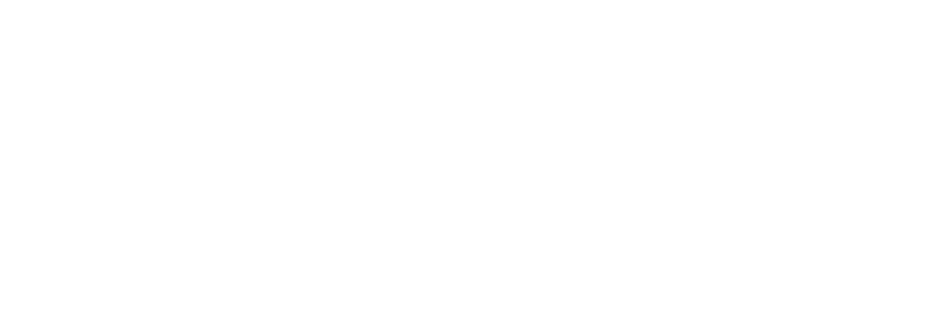

In [24]:
X_train, X_test, y_train, y_test = train_processed.drop(columns=[settings.dropout_column]),train_processed[settings.dropout_column],pred_processed.drop(columns=[settings.dropout_column]),pred_processed[settings.dropout_column]
X_train_sdd, X_test_sdd, y_train_sdd, y_test_sdd = train_df_sdd.drop(columns=[settings.dropout_column]),train_df_sdd[settings.dropout_column],pred_df_sdd.drop(columns=[settings.dropout_column]),pred_df_sdd[settings.dropout_column]
# drop_cols = [settings.studentnumber_column]
# dr_cols = 
test_data_rf = pd.concat([X_test, y_test], axis=1)
test_data_sdd = pd.concat([X_test_sdd, y_test_sdd], axis=1)
model_predictions = {
        'Random Forest': (test_data_rf, best_rf_model, False),
        'Lasso': (test_data_sdd, best_lasso_model, True),
        'SVM': (test_data_sdd, best_svm_model, True)
    }
    
evaluation_results = generate_stoplight_evaluation(
        model_predictions,
        invite_pct=20
    )
save_model_metrics(
            train_data=pd.concat([X_train, y_train], axis=1),
            train_data_scaled=pd.concat([X_train_sdd, y_train_sdd], axis=1),
            validation_data=test_data_rf,
            validation_data_scaled=test_data_sdd,
            rf_model=best_rf_model,
            lasso_model=best_lasso_model,
            svm_model=best_svm_model
        )
save_threshold_analysis(
            train_data=pd.concat([X_train, y_train], axis=1),
            train_data_scaled=pd.concat([X_train_sdd, y_train_sdd], axis=1),
            validation_data=test_data_rf,
            validation_data_scaled=test_data_sdd,
            rf_model=best_rf_model,
            lasso_model=best_lasso_model,
            svm_model=best_svm_model
        )